In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import seed
from io import StringIO



In [21]:
# Load the dataset
dataset = pd.read_csv("diabetes2.csv")
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# Replace the Nan values with 0
dataset[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = dataset[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)


In [8]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc523d21a90>,
      dtype=object)

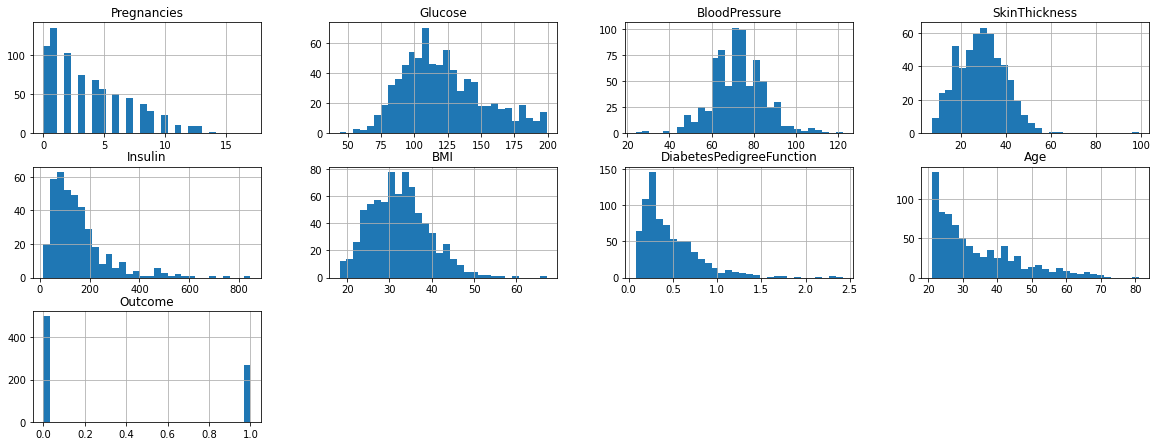

In [9]:
dataset.hist(figsize=(20,10), grid = True, layout=(4, 4), bins = 30)

In [10]:
stringData =  dataset.select_dtypes(include=[np.object]).columns
print(stringData)

Index([], dtype='object')


In [11]:
# check the missing points
missing = dataset.isnull().sum().sort_values(ascending = False)
percentageMissing = (missing/len(dataset))*100
pd.concat([missing, percentageMissing], axis = 1, keys= ['Number of missing values ', 'Percentage of Missing Values'])

,Number of missing values,Percentage of Missing Values
Insulin,374,48.697917
SkinThickness,227,29.557292
BloodPressure,35,4.557292
BMI,11,1.432292
Glucose,5,0.651042
Outcome,0,0.000000
Age,0,0.000000
DiabetesPedigreeFunction,0,0.000000
Pregnancies,0,0.000000


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


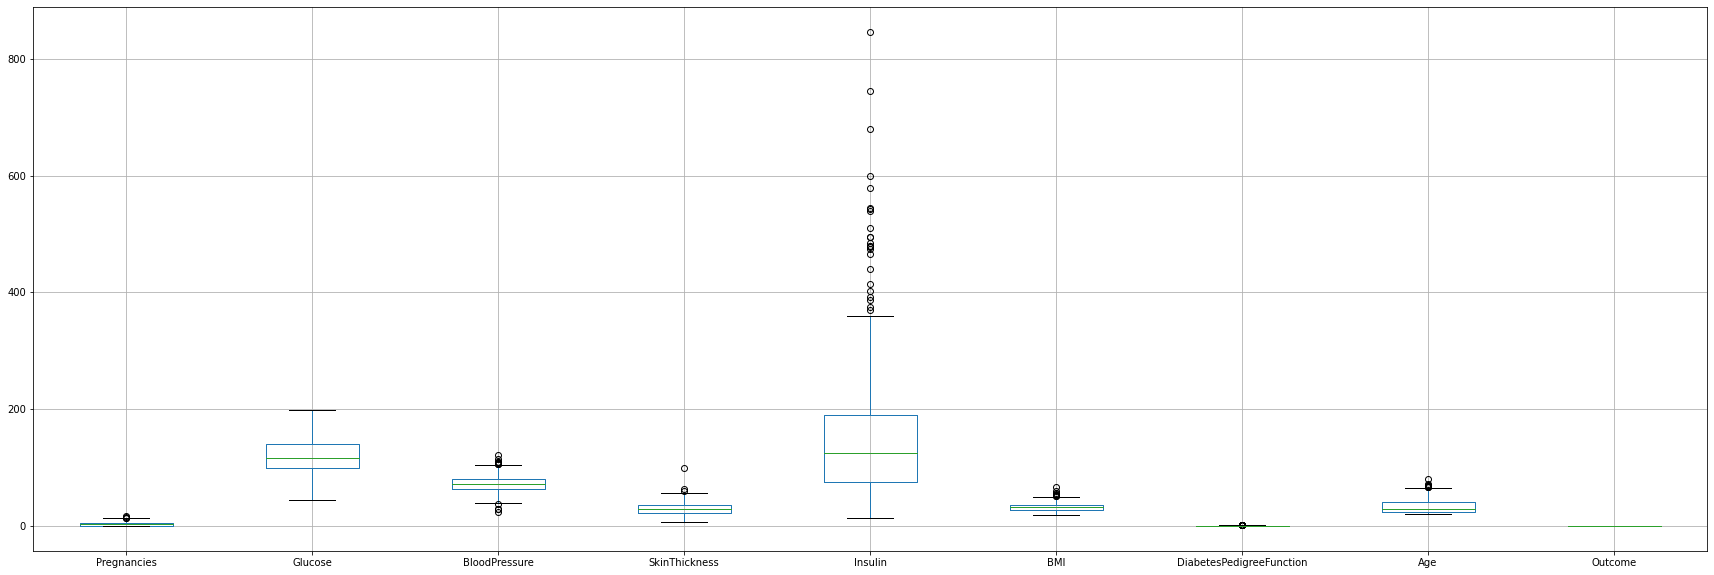

In [12]:
dataset.boxplot(figsize = (30, 10))

In [22]:
#Replacing the zero-values for Blood Pressure
df1 = dataset.loc[dataset['Outcome'] == 1]
df2 = dataset.loc[dataset['Outcome'] == 0]
df1 = df1.replace({'BloodPressure':0}, np.median(df1['BloodPressure']))
df2 = df2.replace({'BloodPressure':0}, np.median(df2['BloodPressure']))
dataframe = [df1, df2]
dataset = pd.concat(dataframe)

In [23]:
# Getting the values of y and X separately
y = dataset.Outcome.values
del dataset["Outcome"]
X = dataset.values.astype(np.float)

In [24]:
# Splitting into training, validation and test sets
seed(0)
indices = list(range(X.shape[0]))
training_instances = int(0.7*X.shape[0])
validation_instances = int(0.2 * X.shape[0])
np.random.shuffle(indices)
train = indices[:training_instances]
validation = indices[training_instances:training_instances + validation_instances + 1]
test = indices[training_instances + validation_instances + 1:]

In [25]:
X_train, X_validation, X_test = X[train], X[validation], X[test]
y_train, y_validation, y_test = y[train], y[validation], y[test]

In [26]:
# Noramlising the data
means = np.mean(X_train, axis = 0)
stds = np.std(X_train, axis = 0)

X_train = (X_train - means)/stds
X_validation = (X_validation - means)/stds
X_test = (X_test - means)/stds



# adding an extra column for intercept
X_train = np.column_stack(([1] * X_train.shape[0], X_train))
X_test = np.column_stack(([1]*X_test.shape[0], X_test))
X_validation = np.column_stack(([1]*X_validation.shape[0], X_validation))

In [27]:
# Logistic Regression functions
def sigmoid(X):
  return 1/(1 + np.exp(-X))

# Mean Squared Error
def mse(y, yProb):
    return np.square(np.subtract(y, yProb)).mean()

# Log based cost function
def cost(y, yProb):
  sizeY = len(y)
  cost = -1/(sizeY) * sum((y*np.log(yProb)) + (1 - y) * np.log(1 - yProb))
  return cost


# SGD
def stochasticGradientDescent(X, y, coeffMatrix, alpha, n_iters, X_valid, y_valid):

  costValues = [0]*n_iters
  costValuesValidation = [0]*n_iters
  sizeY = len(y)
  
  for iter in range(n_iters):
    yPrime = np.matmul(X, coeffMatrix)
    yProb = sigmoid(yPrime)

    costVal = mse(y, yProb)
    costValues[iter] = costVal

    # Calculating validation error
    costValValidation = mse(y_valid, sigmoid(np.matmul(X_valid, coeffMatrix)))
    costValuesValidation[iter] = costValValidation

    updateCoeff = []
    for col in range(X.shape[1]):
      # updating the theta for mean value of X.
      coeff = round(coeffMatrix[col] - alpha/sizeY * sum((yProb - y) * X[: , col]), 4)
      updateCoeff.append(coeff)
    
    # Update theta matrix
    coeffMatrix = updateCoeff

  # Final Coefficients and model cost
  print("Final Model Coefficients: ")
  print(coeffMatrix)
  print("Final Model Cost: ")
  print(costValues[-1])

  return coeffMatrix, costValues, costValuesValidation


# BGD
def BatchGradientDescent(X, y, coeffMatrix, alpha, n_iters, X_valid, y_valid):
    costValues = [0] * (n_iters)
    costValuesValidation = [0]*n_iters
    sizeY = len(y)
  
    for iter in range(n_iters):
      # Updating the entire theta matrix at once.
      # calculating sigmoid y
      yProb = sigmoid(np.dot(X, coeffMatrix.T))

      costValues[iter] = mse(yProb, y)

      # Calculating validation error
      costValValidation = mse(y_valid, sigmoid(np.matmul(X_valid, coeffMatrix)))
      costValuesValidation[iter] = costValValidation


      # Calculate gradient
      gradient = alpha * (1/sizeY) * (yProb - y).dot(X)

      # Update theta
      coeffMatrix = coeffMatrix - gradient
      
    # Final Coefficients and model cost
    print("Final Model Coefficients: ")
    print(coeffMatrix)
    print("Final Model Cost: ", costValues[-1])

        
    return coeffMatrix, costValues, costValuesValidation


def LogisticRegressionS(X, y, alpha, n_iters, X_valid, y_valid, category = "SGD"):

    # Initial coeffMatrix
    coeffMatrix = np.zeros((len(X[0])))

    # Calculate the initial cost
    yP = np.matmul(X, coeffMatrix)
    initialCost = cost(y, sigmoid(yP))
    print("Initial Model Cost: ", initialCost)

    # Calling the gradient descent with alpha and number of iterations
    
    if category == "SGD":
      coeffMatrix, costValues, validationErrors = stochasticGradientDescent(X, y, coeffMatrix, alpha, n_iters, X_valid, y_valid)
    
    else:
      coeffMatrix, costValues, validationErrors = BatchGradientDescent(X, y, coeffMatrix, alpha, n_iters, X_valid, y_valid)

    return coeffMatrix, costValues, validationErrors

def predict(X, coeffMatrix):

  # Linear Regression
  yPrime = np.matmul(X, coeffMatrix) 

  # Calculate sigmoid function
  yProb = sigmoid(yPrime) 

  # Predict
  y_pred = [1 if y > 0.5 else 0 for y in yProb]

  return y_pred 



Initial Model Cost:  0.6931471805599468
Final Model Coefficients: 
[-0.8956, 0.3242, 1.0055, 0.0121, -0.0756, -0.1241, 0.6813, 0.2817, 0.13]
Final Model Cost: 
0.14594275086290218


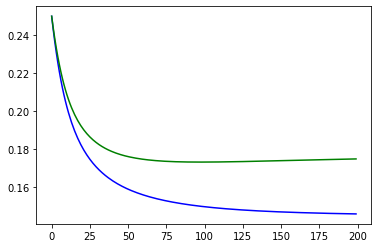

In [31]:
# 1st Model using SGD
iters = 200
a = 0.1
logisticModel, costValues, validationErrors = LogisticRegressionS(X_train, y_train, a, iters, X_validation, y_validation, "SGD")


# Plot iteration vs training loss and validation errors.
plt.plot(list(range(iters)), costValues, 'b')
plt.plot(list(range(iters)), validationErrors, 'g')
plt.show()

Initial Model Cost:  0.6931471805599468
Final Model Coefficients: 
[-0.2682, 0.1358, 0.3244, 0.092, 0.0195, 0.0403, 0.2062, 0.116, 0.1177]
Final Model Cost: 
0.1815486457823289


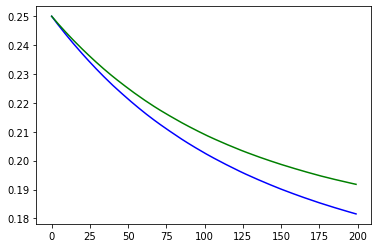

Initial Model Cost:  0.6931471805599468
Final Model Coefficients: 
[-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Final Model Cost: 
0.25


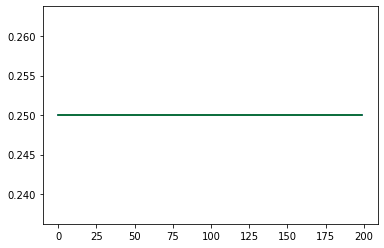

Initial Model Cost:  0.6931471805599468
Final Model Coefficients: 
[-1.4139, 0.0344, 1.8529, -0.3511, 0.5984, 0.3244, 1.5665, 0.8033, -0.6184]
Final Model Cost: 
0.19784432812687042


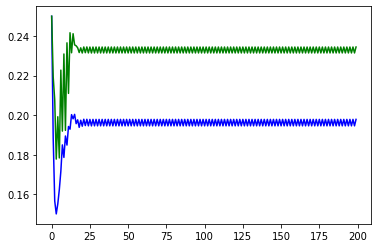

In [32]:
# 2. 1. (b)
# Different Learing Rates. 
LearningRates = [0.01, 0.00001, 10]

for lr in LearningRates:
  logisticModel, costValues, validationErrors = LogisticRegressionS(X_train, y_train, lr, iters, X_validation, y_validation, "SGD")
  
  # Plot iteration vs training loss and validation errors.
  plt.plot(list(range(iters)), costValues, 'b')
  plt.plot(list(range(iters)), validationErrors, 'g')
  plt.show()


In [35]:
iters = 100
a = 0.01
logisticModel, costValues, validationErrors = LogisticRegressionS(X_train, y_train, a, iters, X_validation, y_validation, "SGD")
yTest_pred = predict(X_test, logisticModel)


fp = 0
fn = 0

tp = 0
tn = 0

for actual_value, predicted_value in zip(y_test, yTest_pred):
    if predicted_value == actual_value:
        if predicted_value == 1:
            tp += 1
        else:
            tn += 1
    else: 
        if predicted_value == 1:
            fp += 1
        else:
            fn += 1
            
confusionMatrix = [[tn, fp], [fn, tp]]

confusionMatrix = np.array(confusionMatrix)
print("The confusion matrix: ")
print(confusionMatrix)
print()

f1_score = tp/(tp + (fp + fn)/2)
print("The f1 score is: ", f1_score, "\n")

precision = tp/(tp + fp)
print("The precision is: ", precision, "\n")

recall = tp/(tp + fn)
print("The recall is: ", recall, "\n")

accuracy = (tp + tn)/(tp+tn+fn+fp)
print("The accuracy is: ", accuracy, "\n")



Initial Model Cost:  0.6931471805599468
Final Model Coefficients: 
[-0.1495, 0.0836, 0.1893, 0.0614, 0.0174, 0.0312, 0.1211, 0.0704, 0.0767]
Final Model Cost: 
0.20293888260602883
The confusion matrix: 
[[38  9]
 [14 16]]

The f1 score is:  0.5818181818181818 

The precision is:  0.64 

The recall is:  0.5333333333333333 

The accuracy is:  0.7012987012987013 



Initial Model Cost:  0.6931471805599468
Final Model Coefficients: 
[-0.7271697   0.271571    0.80041528  0.08168868 -0.03989087 -0.03767576
  0.52006547  0.24469563  0.15409408]
Final Model Cost:  0.14981348874995823


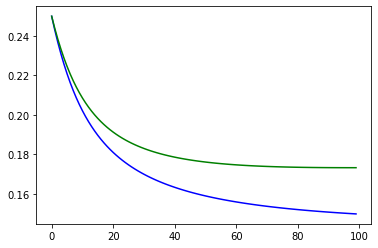

In [36]:
# Models using BGD.
iters = 100
a = 0.1
logisticModel, costValues, validationErrors = LogisticRegressionS(X_train, y_train, a, iters, X_validation, y_validation, "BGD")


# Plot iteration vs training loss and validation errors.
plt.plot(list(range(iters)), costValues, 'b')
plt.plot(list(range(iters)), validationErrors, 'g')
plt.show()

Initial Model Cost:  0.6931471805599468
Final Model Coefficients: 
[-0.14954178  0.08344099  0.1891629   0.06153227  0.0174964   0.03128463
  0.12130003  0.0701579   0.07651399]
Final Model Cost:  0.2029457616930269


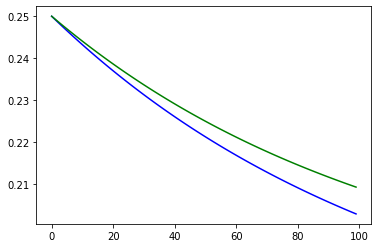

Initial Model Cost:  0.6931471805599468
Final Model Coefficients: 
[-1.68508010e-04  1.05608555e-04  2.26925125e-04  8.39578643e-05
  2.95825210e-05  4.80189079e-05  1.47350271e-04  8.75737518e-05
  1.01913610e-04]
Final Model Cost:  0.24993018473678533


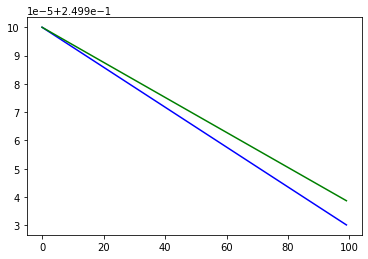

Initial Model Cost:  0.6931471805599468
Final Model Coefficients: 
[-1.41393347  0.03436338  1.85285522 -0.35110084  0.59841189  0.32439765
  1.56647374  0.80325815 -0.61835414]
Final Model Cost:  0.19784405600797664


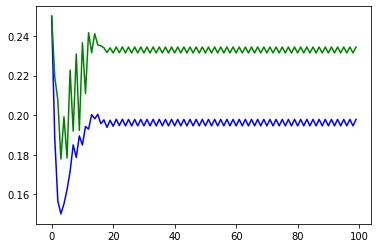

In [37]:
# 2. 1. (b)
# Different Learing Rates. 
LearningRates = [0.01, 0.00001, 10]

for lr in LearningRates:
  logisticModel, costValues, validationErrors = LogisticRegressionS(X_train, y_train, lr, iters, X_validation, y_validation, "BGD")
  
  # Plot iteration vs training loss and validation errors.
  plt.plot(list(range(iters)), costValues, 'b')
  plt.plot(list(range(iters)), validationErrors, 'g')
  plt.show()


In [38]:
iters = 100
a = 0.01
logisticModel, costValues, validationErrors = LogisticRegressionS(X_train, y_train, a, iters, X_validation, y_validation, "BGD")
yTest_pred = predict(X_test, logisticModel)


fp = 0
fn = 0

tp = 0
tn = 0

for actual_value, predicted_value in zip(y_test, yTest_pred):
    if predicted_value == actual_value:
        if predicted_value == 1:
            tp += 1
        else:
            tn += 1
    else: 
        if predicted_value == 1:
            fp += 1
        else:
            fn += 1
            
confusionMatrix = [[tn, fp], [fn, tp]]

confusionMatrix = np.array(confusionMatrix)
print("The confusion matrix: ")
print(confusionMatrix)
print()

f1_score = tp/(tp + (fp + fn)/2)
print("The f1 score is: ", f1_score, "\n")

precision = tp/(tp + fp)
print("The precision is: ", precision, "\n")

recall = tp/(tp + fn)
print("The recall is: ", recall, "\n")

accuracy = (tp + tn)/(tp+tn+fn+fp)
print("The accuracy is: ", accuracy, "\n")



Initial Model Cost:  0.6931471805599468
Final Model Coefficients: 
[-0.14954178  0.08344099  0.1891629   0.06153227  0.0174964   0.03128463
  0.12130003  0.0701579   0.07651399]
Final Model Cost:  0.2029457616930269
The confusion matrix: 
[[38  9]
 [14 16]]

The f1 score is:  0.5818181818181818 

The precision is:  0.64 

The recall is:  0.5333333333333333 

The accuracy is:  0.7012987012987013 



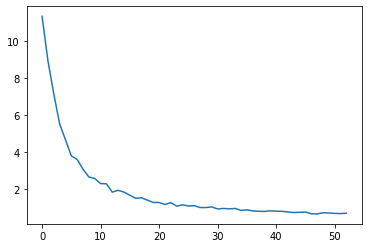

In [44]:
from sklearn.linear_model import SGDClassifier
import sys

Oldstdout = sys.stdout
sys.stdout = mystdout = StringIO()

LogisticRegressionModel = SGDClassifier(loss = 'log', verbose = '1')
LogisticRegressionModel.fit(X_train, y_train)
yTest_pred = LogisticRegressionModel.predict(X_test)

sys.stdout = Oldstdout
epochVals = mystdout.getvalue()

yTest_pred = LogisticRegressionModel.predict(X_test)

# Get loss plots
lossValues = []
for i in epochVals.split('\n'):
    if(len(i.split("loss: ")) == 1):
        continue
    lossValues.append(float(i.split("loss: ")[-1]))

# Plot loss curve per epoch
plt.plot(np.arange(len(lossValues)), lossValues)
plt.show()


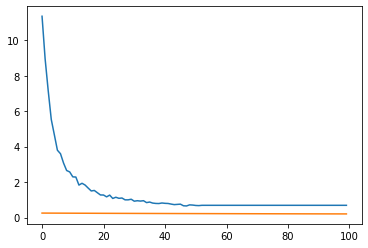

In [45]:
FinalLoss = lossValues[-1]
for i in range(len(lossValues), len(costValues)):
  lossValues.append(FinalLoss)



plt.plot(np.arange(len(lossValues)), lossValues)
plt.plot(np.arange(len(lossValues)), costValues)
plt.show()

In [46]:
fp = 0
fn = 0

tp = 0
tn = 0

for actual_value, predicted_value in zip(y_test, yTest_pred):
    if predicted_value == actual_value:
        if predicted_value == 1:
            tp += 1
        else:
            tn += 1
    else: 
        if predicted_value == 1:
            fp += 1
        else:
            fn += 1
            
confusionMatrix = [[tn, fp], [fn, tp]]

confusionMatrix = np.array(confusionMatrix)
print("The confusion matrix: ")
print(confusionMatrix)
print()

f1_score = tp/(tp + (fp + fn)/2)
print("The f1 score is: ", f1_score, "\n")

precision = tp/(tp + fp)
print("The precision is: ", precision, "\n")

recall = tp/(tp + fn)
print("The recall is: ", recall, "\n")

accuracy = (tp + tn)/(tp+tn+fn+fp)
print("The accuracy is: ", accuracy, "\n")



The confusion matrix: 
[[38  9]
 [15 15]]

The f1 score is:  0.5555555555555556 

The precision is:  0.625 

The recall is:  0.5 

The accuracy is:  0.6883116883116883 

